<a href="https://colab.research.google.com/github/haiderzm/ReinforcementLearningWithGym/blob/main/BreakoutAtariDeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
from collections import namedtuple
from itertools import count
import IPython.display  as ipydisplay
import math
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ROMS.zip to ROMS.zip
Saving HC ROMS.zip to HC ROMS.zip


In [ ]:
!python -m atari_py.import_roms .

copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

In [ ]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(4, 32, kernel_size=8, stride=4),
                                        nn.ReLU(True),
                                        nn.Conv2d(32, 64, kernel_size=4, stride=2),
                                        nn.ReLU(True),
                                        nn.Conv2d(64, 64, kernel_size=3, stride=1),
                                 nn.ReLU(True)
                                        )
        self.classifier = nn.Sequential(nn.Linear(7*7*64, 512),
                                        nn.ReLU(True),
                                        nn.Linear(512, 4)
                                        )
        
    def forward(self,x):
        x = self.cnn(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
env = gym.make('BreakoutDeterministic-v4')

for i in range(5):
    env.reset()
    done = False
    score = 0
    while not done:
        action = random.randrange(env.action_space.n)
        n_state, reward, done, _ = env.step(action)
        score += reward
#         print(done,i)
        env.render('ipython')
    time.sleep(1)
    if score > 0:
        print("Episode : ",i+1,"Reward : ",score)
env.close()

Episode :  1 Reward :  3.0
Episode :  2 Reward :  1.0
Episode :  3 Reward :  1.0


In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.count % self.capacity] = experience
        self.count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide(self, batch_size):
        return len(self.memory) > batch_size


In [ ]:
class EpsilonGreedy():
    def __init__(self, ep_max, ep_min, ep_decay):
        self.max = ep_max
        self.min = ep_min
        self.decay = ep_decay

    def get_exploration_rate(self, cur_step):
        return self.min + (self.max - self.min)*math.exp(-1*cur_step*self.decay)

In [ ]:
class Agent():
    def __init__(self, strategy, num_action, device):
        self.strategy = strategy 
        self.num_action = num_action
        self.cur_step = 0 
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.cur_step)
        self.cur_step += 1 

        if rate > random.random():
            return torch.tensor([random.randrange(self.num_action)])#.to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1)#.to(self.device)

In [ ]:
class AtariEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('BreakoutDeterministic-v4')
        self.env.reset()
        self.done = False
        self.cur_screen = None
        self.running_K = 4
        self.running_queue = []
        self.is_additional_ending = False 
        self.current_lives = None
#         self.is_use_additional_ending_criterion = is_use_additional_ending_criterion
        
    def reset(self):
        self.env.reset()
        self.cur_screen = None
        self.running_queue = [] 
        self.is_additional_ending = False
        
    def close(self):
        self.env.close()
        
    def render(self,mode='human'):
        return self.env.render(mode)
    
    def num_actions(self):
        return self.env.action_space.n
    
    def print_action_meanings(self):
        print(self.env.get_action_meanings())
        
    def take_action(self, action):
        _, reward, self.done, lives = self.env.step(action.item())
    
#         if self.is_use_additional_ending_criterion:
#             self.is_additonal_ending_criterion_met(lives,reward)
        return torch.tensor([reward])#, device=self.device)
    
    def just_starting(self):
        return self.cur_screen is None
    
    def is_initial_action(self):
        return sum(self.running_queue).sum() == 0

    def init_running_queue(self):
        self.cur_screen = self.get_processed_screen()
        black_screen = torch.zeros_like(self.cur_screen)
        for _ in range(self.running_K):
            self.running_queue.append(black_screen)

    def get_state(self):
        if self.just_starting():
            self.init_running_queue()
        elif self.done:# or self.is_additional_ending:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            self.running_queue.pop(0)
            self.running_queue.append(black_screen)
        else: 
            s2 = self.get_processed_screen()
            self.cur_screen = s2
            self.running_queue.pop(0)
            self.running_queue.append(s2)
        
        return torch.stack(self.running_queue,dim=1).squeeze(2)
    
#     def is_additonal_ending_criterion_met(self,lives,reward):
#         if self.is_initial_action():
#             self.current_lives = lives['ale.lives']
#         elif lives['ale.lives'] < self.current_lives:
#             self.is_additional_ending = True
#         else:
#             self.is_additional_ending = False
#         self.current_lives = lives['ale.lives']
#         return False
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))  
        return self.transform_screen_data(screen) 
    
    def crop_screen(self, screen):
        bbox = [34,0,160,160] 
        screen = screen[:, bbox[0]:bbox[2]+bbox[0], bbox[1]:bbox[3]+bbox[1]]
        return screen
    
    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        screen = self.crop_screen(screen)

        resize = T.Compose([
            T.ToPILImage()
            , T.Grayscale()
            , T.Resize((84, 84))
            , T.ToTensor()
        ])
        
        screen = resize(screen)
        
        return screen.unsqueeze(0)#.to(self.device)

In [ ]:
Experience = namedtuple(
    'Experience',
    ('state','action','reward','next_state')
)

In [ ]:
def plot(score, episode):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(episode,score)
    plt.pause(0.001)
    ipydisplay.clear_output(wait=True)

In [ ]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [ ]:
class QValues():
    """
    This is the class that we used to calculate the q-values for the current states using the policy_net,
     and the next states using the target_net
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states, mode = "stacked"):
        if mode == "stacked":
            last_screens_of_state = next_states[:,-1,:,:] #(B,H,W)
            final_state_locations = last_screens_of_state.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
            non_final_state_locations = (final_state_locations == False)
            non_final_states = next_states[non_final_state_locations] #(B',4,H,W)
            batch_size = next_states.shape[0]
            #print("# of none terminal states = ", batch_size)
            values = torch.zeros(batch_size).to(QValues.device)
            if non_final_states.shape[0]==0: # BZX: check if there is survival
                print("EXCEPTION: this batch is all the last states of the episodes!")
                return values
            with torch.no_grad():
                values[non_final_state_locations] = target_net(non_final_states).detach().max(dim=1)[0]
            return values

In [ ]:
batch_size = 300
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 1000000
lr = 0.0001
num_episodes = 300

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = AtariEnvManager(device)
strategy = EpsilonGreedy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions(), device)
memory = ReplayMemory(memory_size)
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

Thu Sep 30 08:40:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    66W / 149W |    847MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

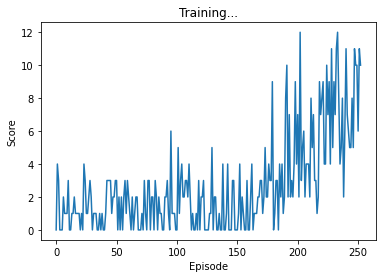

In [ ]:
episodes_done = []
score_obtain = []
for e in range(num_episodes):
    em.reset()
    state = em.get_state()
    score = 0
    for timestep in count():
        action = agent.select_action(state.to(device), policy_net)
        action = action.to('cpu')
        reward = em.take_action(action)
        score += reward.item()
        next_state = em.get_state()
        memory.push(Experience(state, action, reward, next_state))
        state = next_state
        del next_state
        
        if memory.can_provide(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            states, actions, rewards, next_states = states.to(device), actions.to(device), rewards.to(device), next_states.to(device)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # del loss 
            # del current_q_values
            # del next_q_values
            # del target_q_values
            # del rewards
        if em.done:
            episodes_done.append(e)
            score_obtain.append(score)
            #del loss
            !nvidia-smi
            print(torch.cuda.memory_allocated())
            print(torch.cuda.memory_cached())
            print("Episode : ", e,"Score : ",score)
            # ~del score
#             print("Episode : ",episode," Score : ",score)
            plot(score_obtain, episodes_done)
            break
    if e % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    #torch.cuda.empty_cache()

em.close()

In [ ]:
em.reset()
state = em.get_state()
action = agent.select_action(state, policy_net)

In [ ]:
print(action)

tensor([1], device='cuda:0')


In [ ]:
for i in range(5):
    env.reset()
    score = 0
    state = em.get_state()
    for timestep in count():
        action = agent.select_action(state.to(device), policy_net)
        reward = em.take_action(action)
        score += reward.item()
        next_state = em.get_state()
        state = next_state
#         print(done,i)
        if em.done:
          print("Episode : ", i+1," Score : ",score)
          break
env.close()

Episode :  1  Score :  0.0
Episode :  2  Score :  0.0
Episode :  3  Score :  0.0
Episode :  4  Score :  0.0
Episode :  5  Score :  0.0


Tue Sep 28 09:08:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    60W / 149W |  11413MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------